# Project Summary

The main objective of this project is to develop a model to predict the runway length needed for a certain type of millitary aircraft based on public millitary database. Many factors could influence the required runway length including the series, type, category, service country, weight, commission year and other design parameters. This model trys to provide a best match through data analysis thus could predict the runway length code for some newly-developed aircraft. Since it is a duty for the intelligence agencies of every country (governmental, millitary, public, etc.) to monitor the millitary growth of potential enemies, this estimation could help national security to gain first-contact information about the upgrading of equipments. 

## Dataset  Description

The dataset used in this model is the extracted SQLite database of a wargame named "Command: Modern Air/Naval Operations". CMANO is a highly professional modern warfare simulator, which has been introduced into the U.S Navy for training purpose. The software is commercial, while its database describing the properties of millitary units is public. It is also modification-permitted, including a variety of aircrafts, surface ships, submarines, missiles and other weapons. 

In [1]:
import numpy as np
import pandas as pd

from pylab import *
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
import sqlite3
from collections import defaultdict

filename = 'DB3K_444.db3'

enumnamelist = [('EnumAircraftCategory','Category'),('EnumAircraftType','Type'),('EnumOperatorCountry','OperatorCountry'),('EnumAircraftPhysicalSize','PhysicalSizeCode'),('EnumAircraftRunwayLength','RunwayLengthCode')];
predictname = 'RunwayLengthCode'
dataname = 'DataAircraft'
attrnamelist = [('Category','class'), ('Type','class'),('Name','string'),('OperatorCountry','class'),('YearComissioned','time'),('Length','num'),('Span','num'),('Height','num'),('WeightEmpty','num'),('WeightPayload','num'),('ClimbRate','num'),('PhysicalSizeCode','class')]

class dataset(object):
    """All the data and attributes used in this project"""
    """The initialization methods are included"""
    """Data manipulation is limited, but self-conversion of format is included """
    def __init__(self,filename, dataname,predictname,attrnamelist,enumnamelist):
        """filename: the sql file"""
        """dataname: the data sheet name"""
        """attrnamelist: the attribute file list, containing enum of code and name"""
        
        def dataset_readsql(sqlname):
            """Load key dataframes from file"""
            return pd.read_sql_query("SELECT * from " + sqlname, self.sqlfile)
        
        self.sqlfile = sqlite3.connect(filename)
        self.data = dataset_readsql(dataname)
        self.enumdict = dict(zip(list (x[1] for x in enumnamelist),list(dataset_readsql(x[0]) for x in enumnamelist)))
        self.attrnamedict = dict(zip(list (x[0] for x in attrnamelist),list(x[1] for x in attrnamelist)))
        self.predictname = predictname
    
    def indexcode2name(self):
        """Convert the certain index columns with codes to the actual name they mean"""
        """Used for display and visualization of enum attributes"""
        conv = self.data
        for x in self.enumdict:
            datadic = self.enumdict[x]['Description']
            datadic.index = self.enumdict[x]['ID']
            conv[x] = conv[x].replace(datadic.to_dict()) 
        return conv

    
# Load Data
Runway_Data = dataset(filename, dataname,predictname,attrnamelist,enumnamelist)

The basic format of original data is shown below.

In [3]:
Runway_Data.data.head(5)

,ID,Category,Type,Name,Comments,OperatorCountry,OperatorService,YearCommissioned,YearDecommissioned,Length,...,Crew,Agility,ClimbRate,OODADetectionCycle,OODATargetingCycle,OODAEvasiveCycle,TotalEndurance,PhysicalSizeCode,RunwayLengthCode,Hypothetical
0,3,2003,6001,SH-60B Seahawk,-,2101,2002,1991,0,15.2,...,3,1.0,5.7,15,15,2,0,2002,2001,0
1,4,2003,6001,Ka-27PL Helix A,-,2088,2204,1982,1991,11.3,...,3,1.0,8.6,15,15,2,0,2001,2001,0
2,5,2001,6002,Il-38 May,-,2088,2204,1982,1991,39.6,...,8,1.0,3.9,15,20,2,0,2004,2004,0
3,6,2001,2002,F-15E Strike Eagle,-,2101,2001,1995,0,19.3,...,2,4.5,99.9,15,15,2,0,2003,2004,0
4,7,2003,6001,SH-3H Sea King,-,2101,2002,1984,0,16.5,...,4,1.0,7.7,15,20,2,0,2002,2001,0


In [4]:
Runway_Data.attrnamedict

{'Category': 'class',
 'ClimbRate': 'num',
 'Height': 'num',
 'Length': 'num',
 'Name': 'string',
 'OperatorCountry': 'class',
 'PhysicalSizeCode': 'class',
 'Span': 'num',
 'Type': 'class',
 'WeightEmpty': 'num',
 'WeightPayload': 'num',
 'YearComissioned': 'time'}

The above list shows the basic properties of aircraft, each type of aircraft has a unique ID, while the following properties are represented by code: 
* category
* type
* operator country
* physical size
* name
* runway length (the target to predict) 
* name
* commission year
* climb rate
* weight: empty, max and payload

The above attributes are classifcation, numbers, time or string. It is notified that the name could be identical for the series of an aircraft, yet could vary with the design, commissioned country and performance. 

There is a map between the code of some properties and their meaning. The original data and enumerate lists are shown below.

In [5]:
for x in Runway_Data.enumdict:
    print x, '\n' 
    print Runway_Data.enumdict[x].head(10),'\n'

Category 

     ID                  Description
0  1001                         None
1  2001                   Fixed Wing
2  2002  Fixed Wing, Carrier Capable
3  2003                   Helicopter
4  2004                    Tiltrotor
5  2006                      Airship
6  2007                     Seaplane
7  2008                    Amphibian 

OperatorCountry 

     ID Description  YearStart  YearEnd
0  1001        None        NaN      NaN
1  1002     Unknown        NaN      NaN
2  1003     Generic        NaN      NaN
3  1101    Civilian        NaN      NaN
4  1102  Commercial        NaN      NaN
5  1201     Pirates        NaN      NaN
6  1202      Rebels        NaN      NaN
7  1203  Terrorists        NaN      NaN
8  2001   Abu Dhabi        NaN      NaN
9  2002     Albania        NaN      NaN 

PhysicalSizeCode 

     ID                            Description
0  1001                                   None
1  2001          Small Aircraft (Length 0-12m)
2  2002      Medium Aircraft (Leng

The Code 1001 represents some objects that cannot be applied in analysis. Also, many countries' 'yearstart' and 'yearend' columns are NaN, this is because they have been existed for a long while. Only a few historical nations (like Soviet Union) have non-Nan values on these columns. Yet, they may have derivation relationship with some existing countries like Russia. So data wrangling may be applied on these parts.

## Data Visualization

### 1. Total Percentage of Required Runway Length

In [6]:
def plotprocess(dataset,classfication,ifstack):
    """Simplify the plot script"""
    if ifstack == False:
        return dataset.indexcode2name().groupby(classfication).size().plot
    else:
        return dataset.indexcode2name().groupby(classfication).size().unstack(level=1).plot

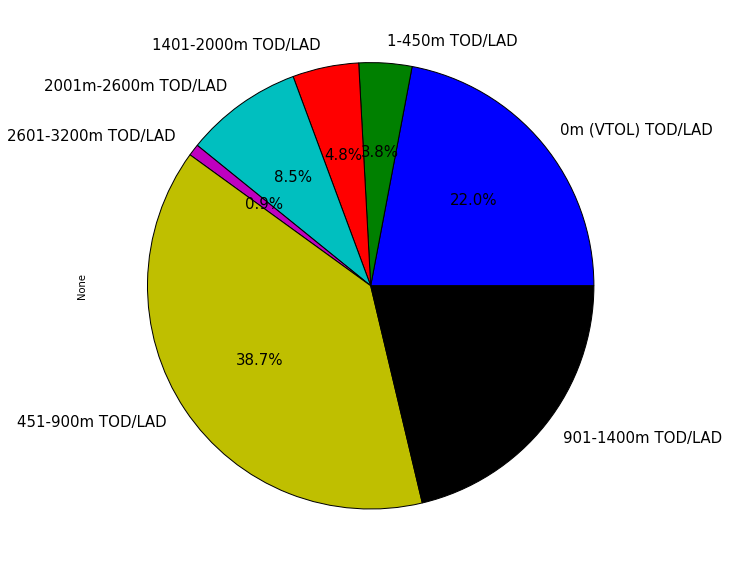

In [7]:
plt.figure()
plotprocess(Runway_Data,['RunwayLengthCode'],False).pie(fontsize=15,figsize=(10, 10),autopct='%1.1f%%')

### 2. Fractions of Various Properties
The category of airplane is shown in the stacked bar plot below.

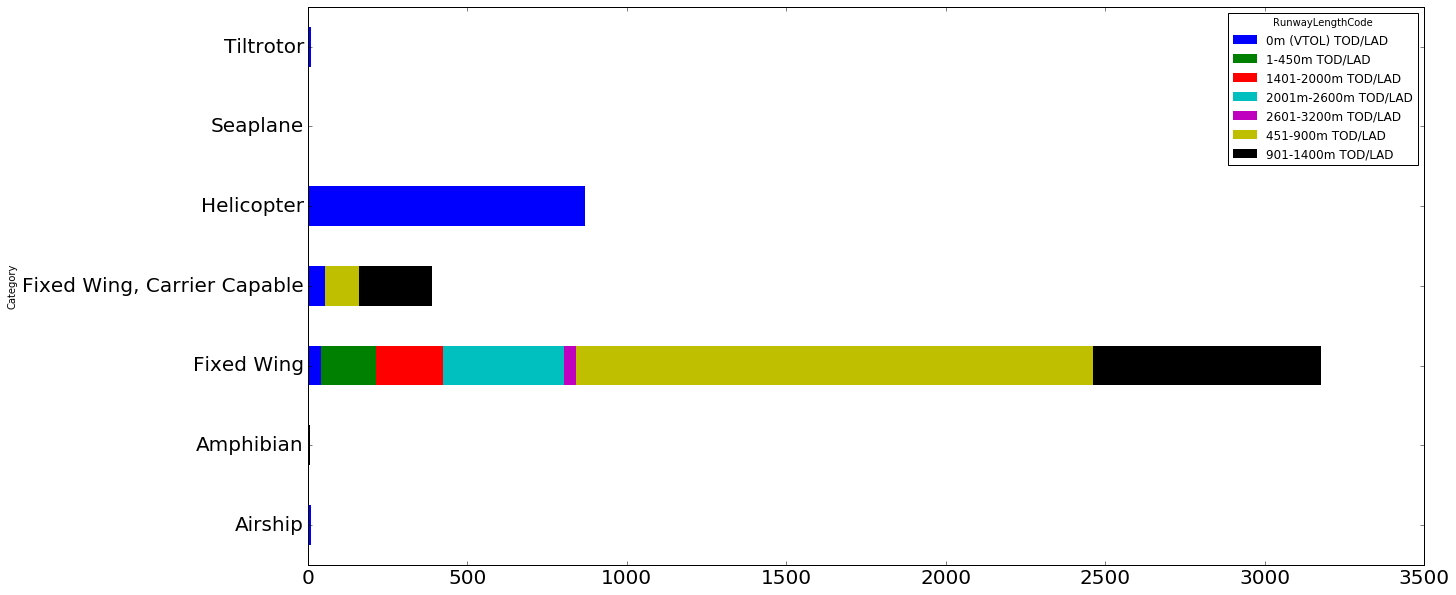

In [8]:
plt.figure()
plotprocess(Runway_Data,['Category','RunwayLengthCode'],True).barh(fontsize=20,figsize=(20, 10),stacked=True,edgecolor='None')

It can be observed that all helicopters,tiltrotors and airships are VTOL. The majority of fixed wing aircraft require 451-900m TOD/LAD, while many carrier capable aircrafts have fraction of 901-1400m TOD/LAD.

Below is the bar plot of different types of aircraft. It is obvious that the fractions of required runway length varies with the mission of aircraft. While combat related (e.g, AAW, ASuW and ASW) aircrafts tend to have shorter runway length, the supporting aircrafts, especially marine surveiliance and air warning aircrafts require longer runway.

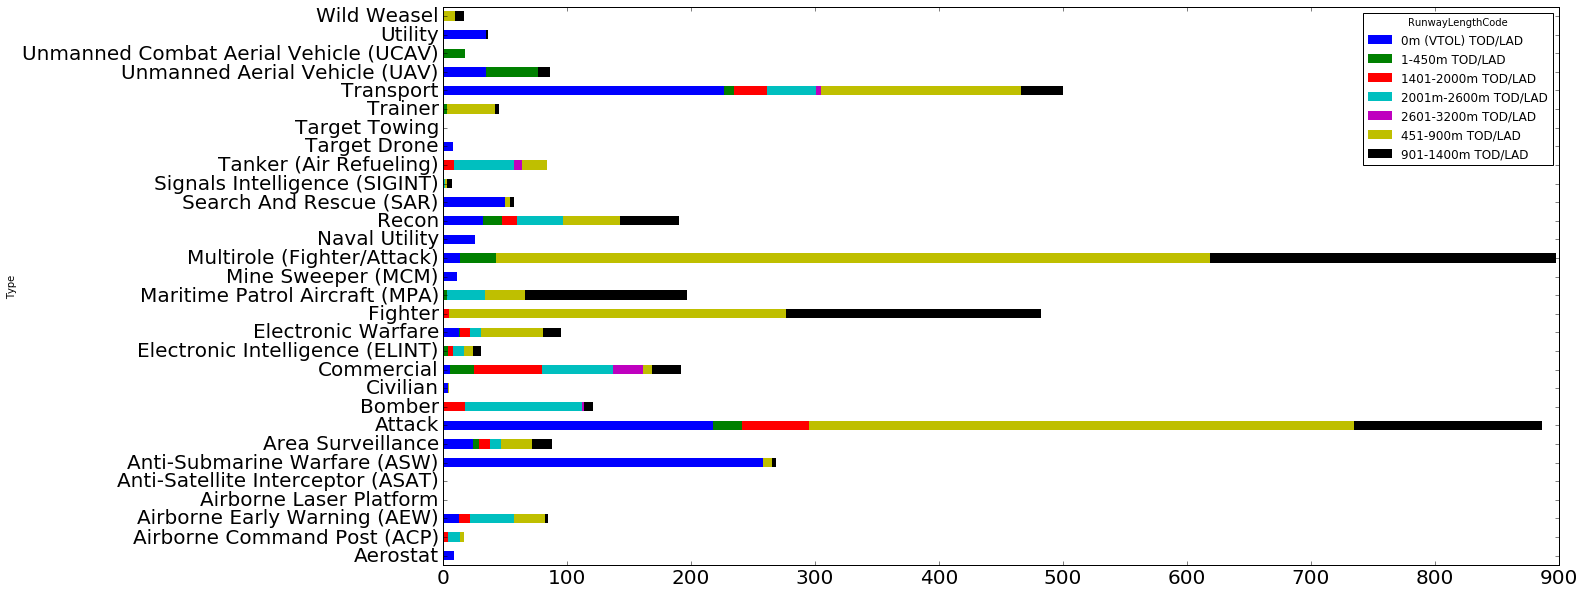

In [9]:
plotprocess(Runway_Data,['Type','RunwayLengthCode'],True).barh(fontsize=20,figsize=(20, 10),stacked=True,edgecolor='None')

Below is the physical size distribution of aircraft. Larger aircraft require longer runway as expected.

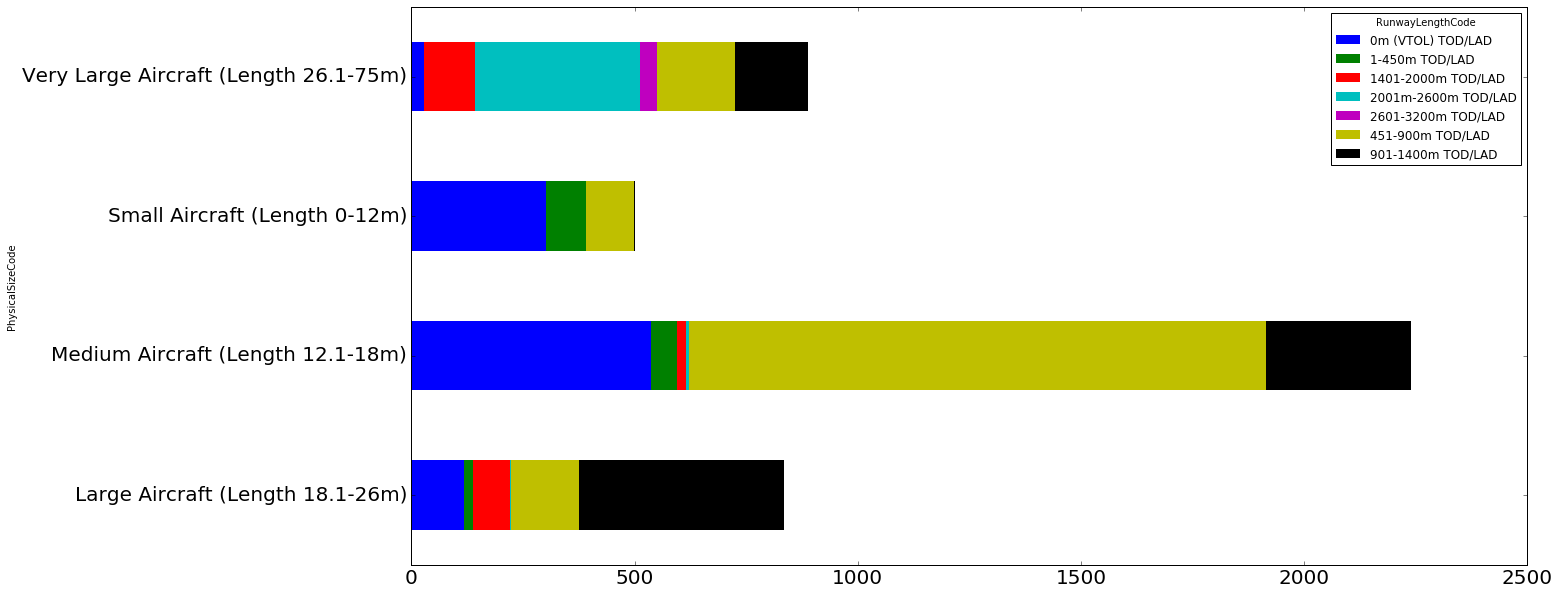

In [10]:
plotprocess(Runway_Data,['PhysicalSizeCode','RunwayLengthCode'],True).barh(fontsize=20,figsize=(20, 10),stacked=True,edgecolor='None')

The strategy for national security and equipment could also have significant influence on the runway length. Even within the same series of aircraft, the runway length required for different countries varies. For example, the supporting AEW and MPA aircrafts of USSR usually require longer runway length than the USA, while the required runway lengths of F-15 fighters are different between Japan (F-15J) and Singapore (F-15E). Since there are many countries, the results cannot be visualized here.

# Statistic Analysis

From the above analysis we can observe the following facts requiring data wrangling:
* All helicopters are VTOL, thus requiring 0m runway length
* The name of aircraft needs to be classified into several series in order to refine the classification. It has quantitative impact on the size of aircraft samples and could influence the classification results. Text analysis should be applied in this case.
* The physical size includes length, width and height while physical size code classified the aircrafts based on the length only. 

### 1. Quantitative Factors
Till now we have not analyzed the quantitative factors including weight, physical size and climb rate in our study. Below are the distribution plots of these factors in respect to the runway length.

In [18]:
import numpy as np
import scipy.stats
import statsmodels.stats.weightstats as st
import sklearn
np.random.seed(len(Runway_Data.data))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efbbbe0c0d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efbba7cee90>]], dtype=object)

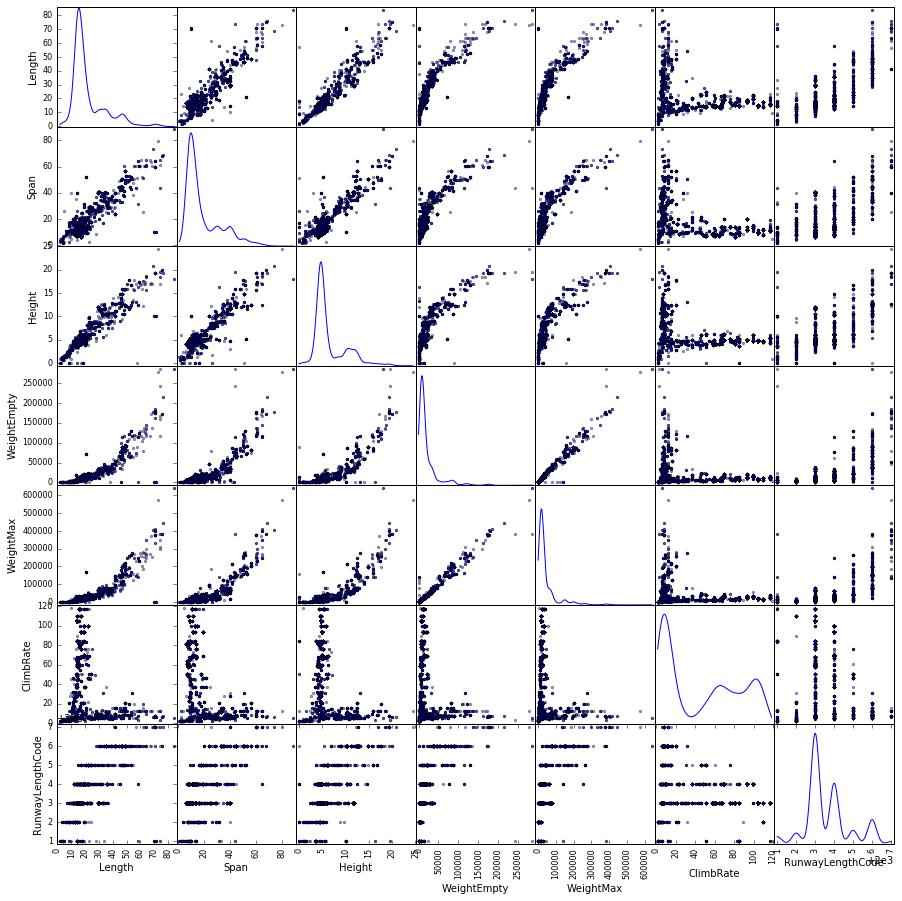

In [65]:
from pandas.tools.plotting import scatter_matrix
# Delete Helicopters

def wrangle(data):
    return data[Runway_Data.data['Category']!=2003]
Wrangle = Runway_Data.data[Runway_Data.data['Category']!=2003]
#Wrangle['Category'].loc[Wrangle['Category']>=2003] = Wrangle['Category'].loc[Wrangle['Category']>=2003].astype(int)-1
sindex = ['Length','Span','Height','WeightEmpty','WeightMax','ClimbRate','RunwayLengthCode']
scatter_matrix(Wrangle[sindex], alpha=0.4, figsize=(15, 15), diagonal='kde')

From the plot we can make several hypothesis:
1. There is significant linear relationship Within the different weight and size parameters.
2. The weight and size parameters could potentially have exponential correlation.
3. The parameters above have a normal distribution.

Since climb rate has two branches,we would like to examine the relationship of each runway size

0    None
Name: Description, dtype: object
1    0m (VTOL) TOD/LAD
Name: Description, dtype: object
2    1-450m TOD/LAD
Name: Description, dtype: object
3    451-900m TOD/LAD
Name: Description, dtype: object
4    901-1400m TOD/LAD
Name: Description, dtype: object
5    1401-2000m TOD/LAD
Name: Description, dtype: object
6    2001m-2600m TOD/LAD
Name: Description, dtype: object
7    2601-3200m TOD/LAD
Name: Description, dtype: object


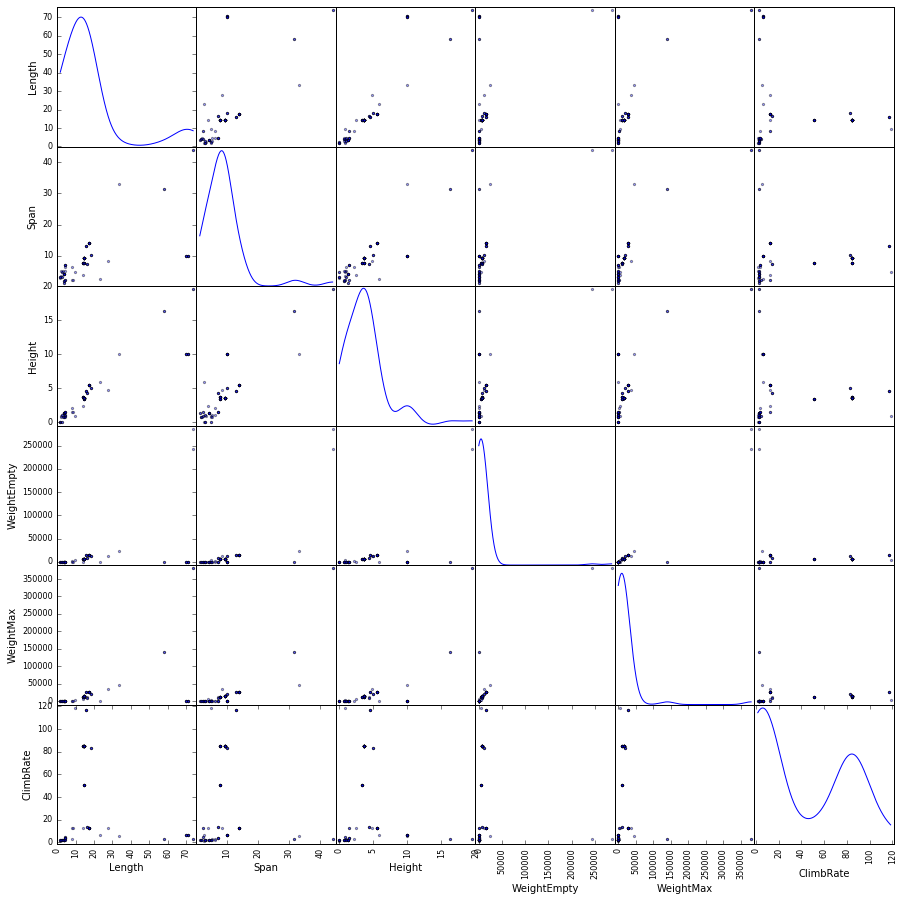

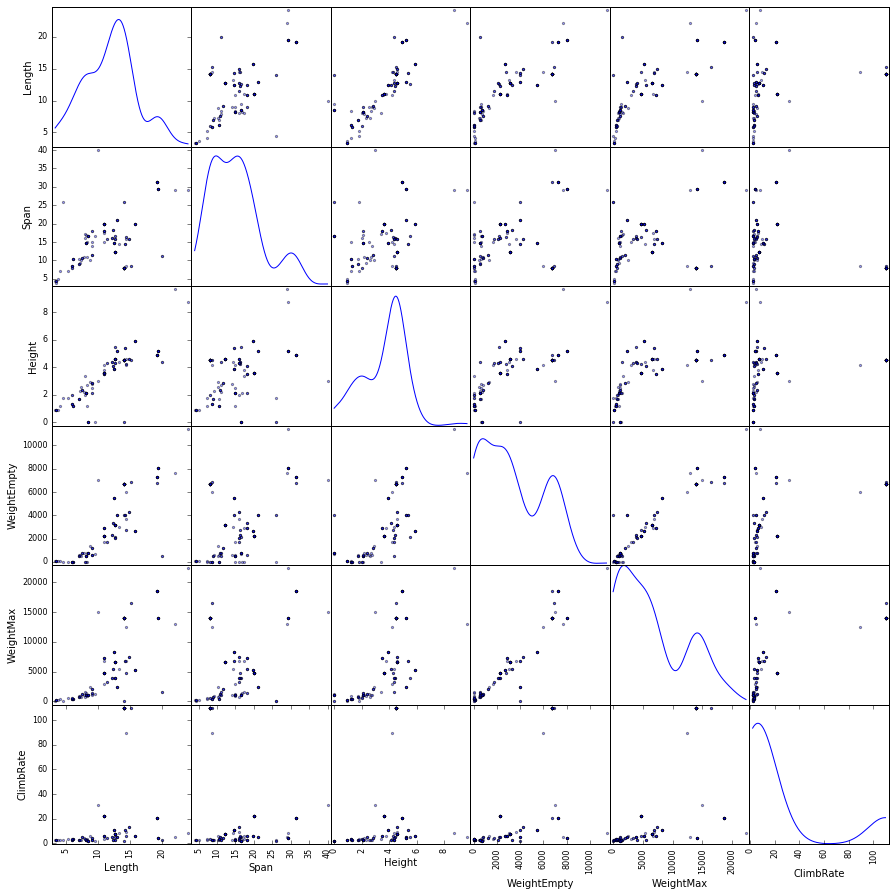

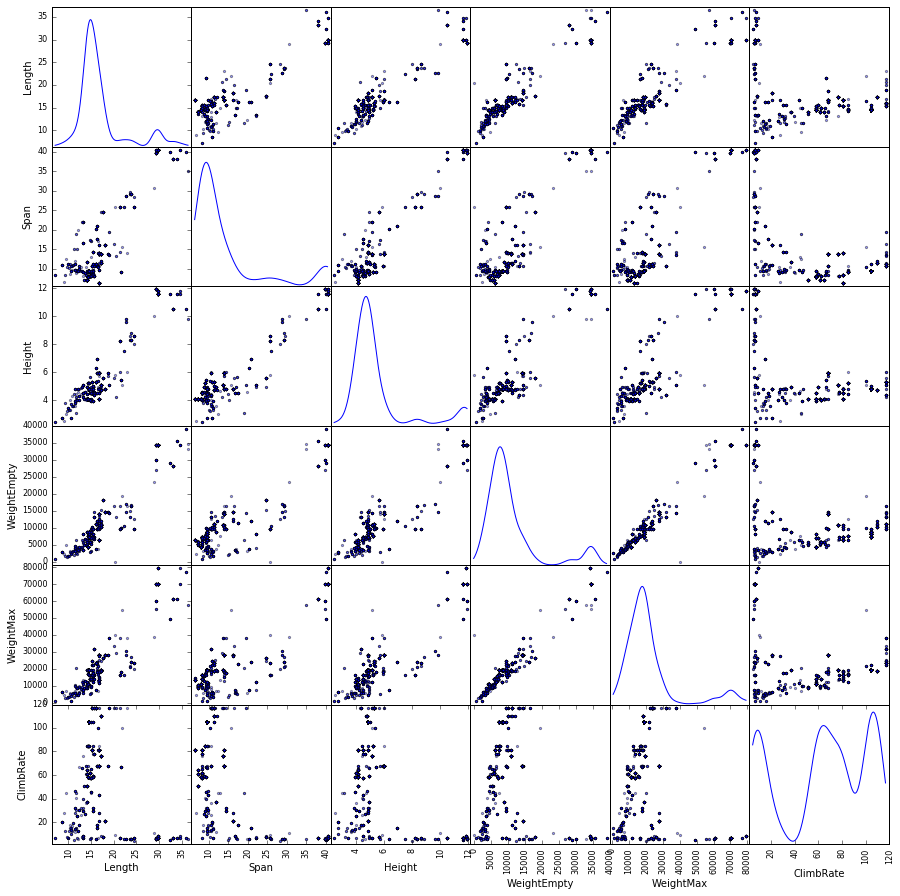

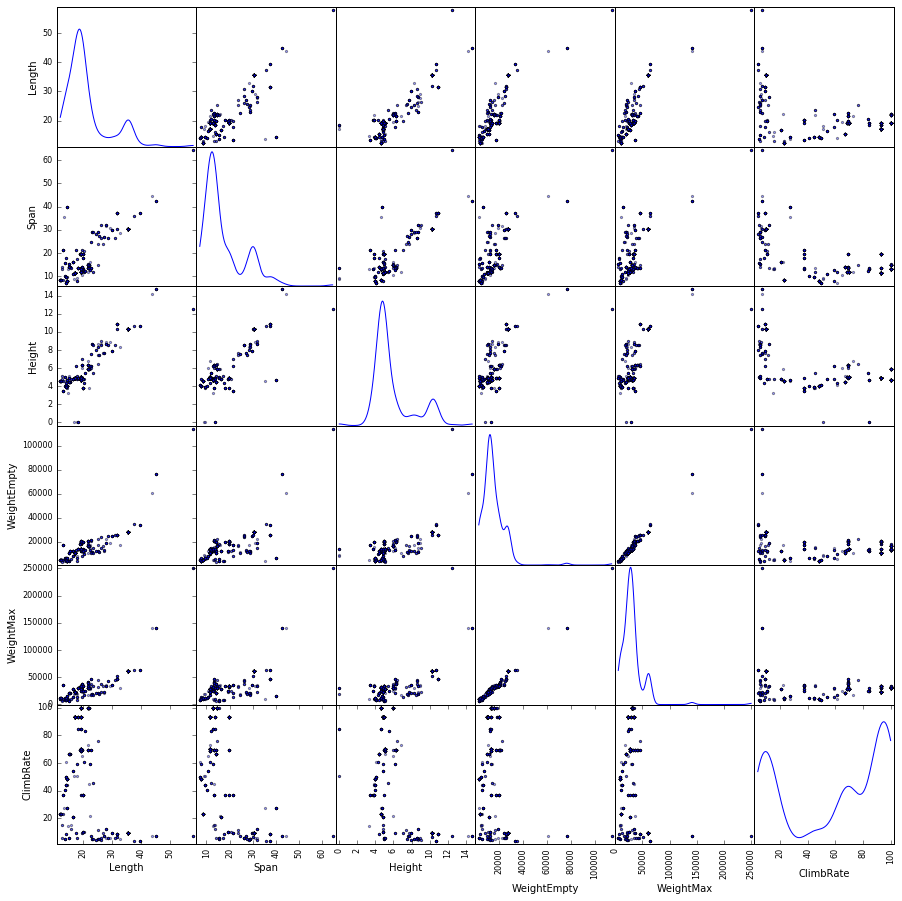

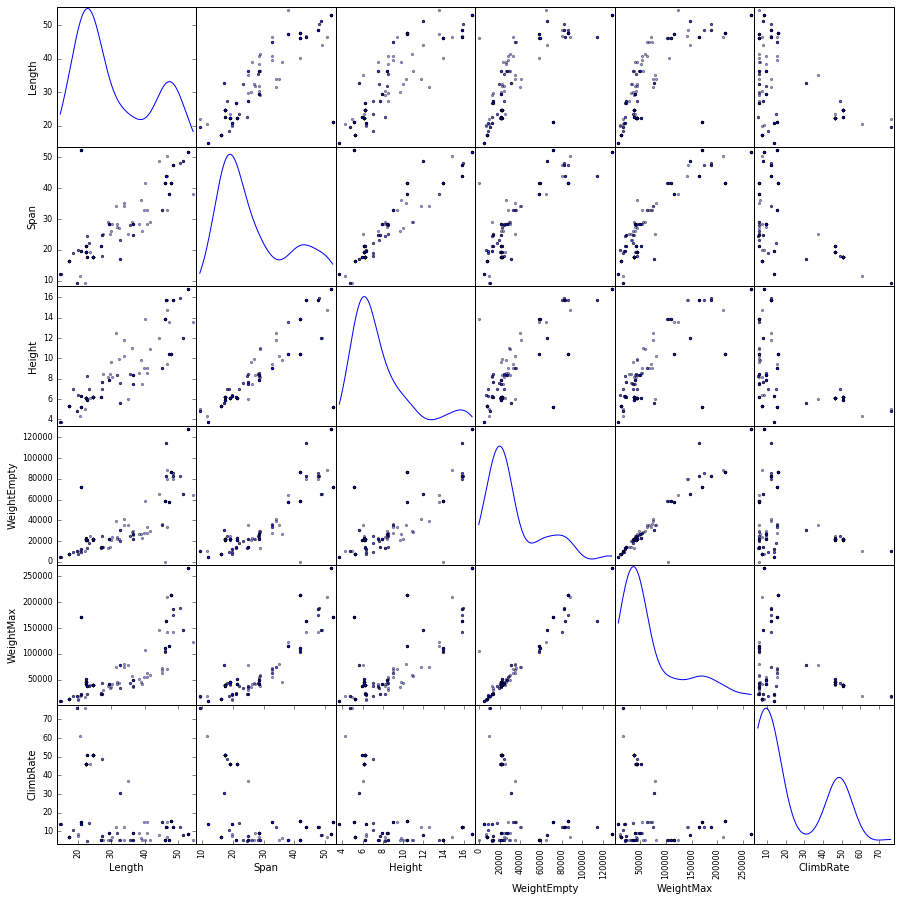

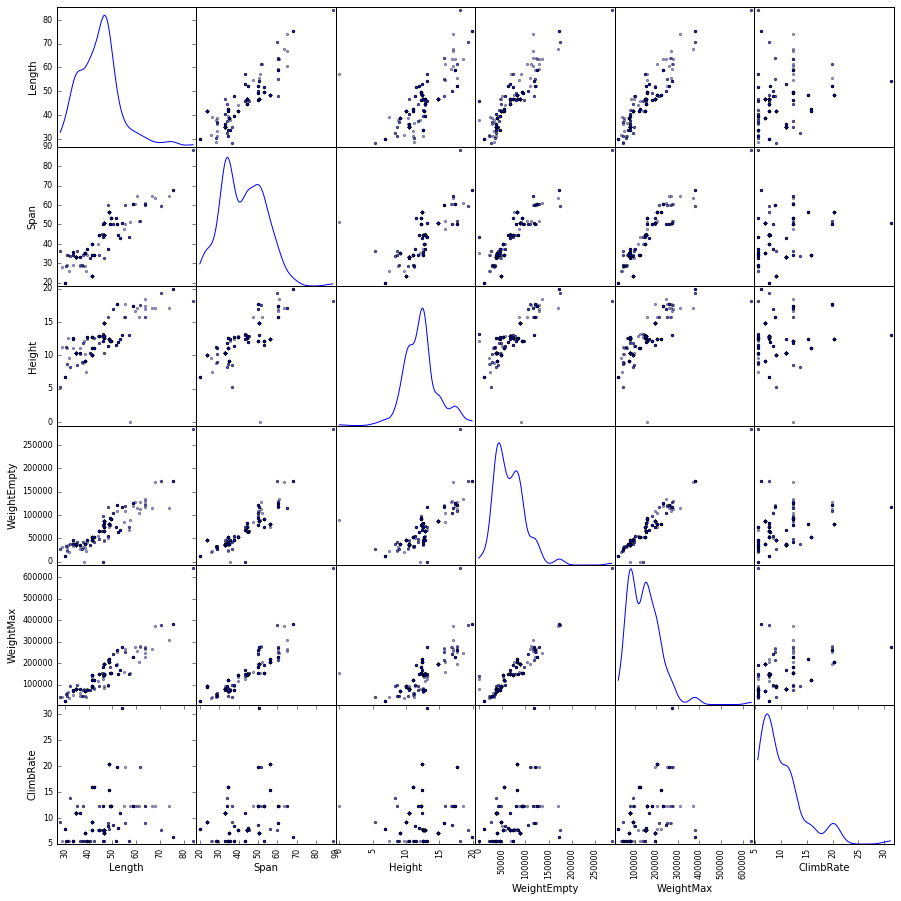

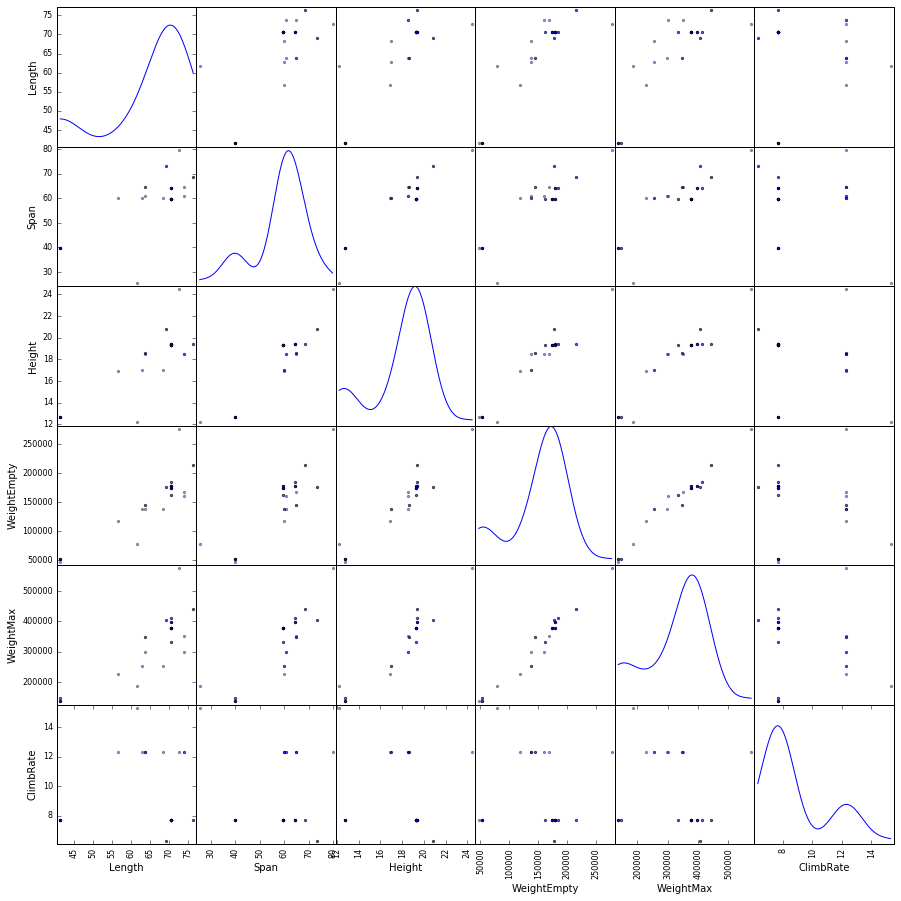

In [81]:
sindex = ['Length','Span','Height','WeightEmpty','WeightMax','ClimbRate']
for i in Runway_Data.enumdict['RunwayLengthCode']['ID']:
    print Runway_Data.enumdict['RunwayLengthCode'][Runway_Data.enumdict['RunwayLengthCode']['ID']==i]['Description']
    if i == 1001:
        continue
    sample = wrangle(Runway_Data.data)
    sample = sample[sample['RunwayLengthCode']==i]
    scatter_matrix(sample[sindex], alpha=0.4, figsize=(15, 15), diagonal='kde')